<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/CondensationCoagulationOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

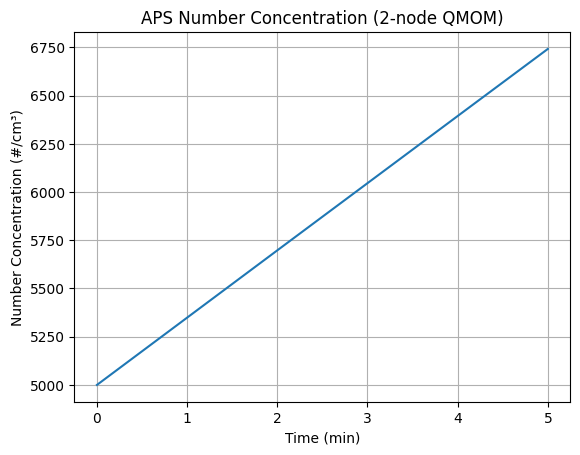

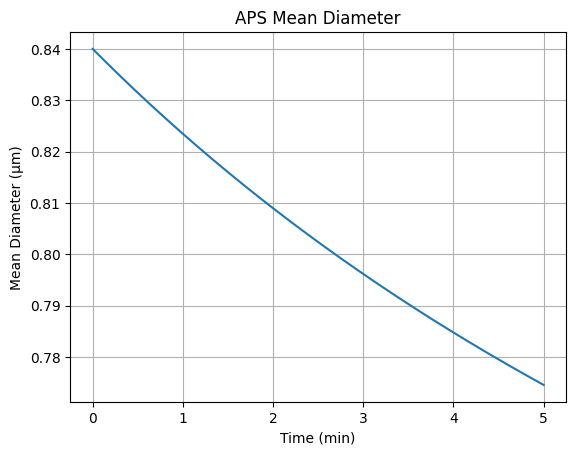

In [2]:
# Condensation and coagulation both on
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --------------------------
# Constants
# --------------------------
g = 9.81
mu = 1.8e-5
rho_p = 1500.0
rho_air = 1.2
H = 1.0          # m, control volume height

# APS detection
D_LOWER = 0.3e-6  # APS detection limit
D_STATS = 0.54e-6

# --------------------------
# Nucleation parameters
# --------------------------
J_in = 6.0e6      # #/m3/s, calibrated from APS data
d0 = 0.35e-6      # m, entry diameter for nucleated particles

# --------------------------
# Coagulation parameters
# --------------------------
K0 = 1e-18        # m^3/s, small to avoid excessive growth

# --------------------------
# Condensation / sub-APS growth
# --------------------------
C_growth = 5e-9   # m/s, small enough to stay below APS window
m_growth = 0.0    # growth independent of size for simplicity

def sub_APS_growth(D):
    """Only grows particles below APS lower cutoff"""
    if D < D_LOWER:
        return C_growth * (D_LOWER - D)/D_LOWER
    else:
        return 0.0

# --------------------------
# Sedimentation
# --------------------------
def settling_velocity(D):
    return (rho_p - rho_air) * g * D**2 / (18 * mu)

def sedimentation_rate(D):
    return settling_velocity(D) / H

# --------------------------
# 2-node QMOM RHS
# --------------------------
# y = [w1, w2, D1, D2]
def rhs(t, y):
    w1, w2, D1, D2 = y

    # Physical bounds
    w1 = max(w1, 0.0)
    w2 = max(w2, 0.0)
    D1 = max(D1, 1e-9)
    D2 = max(D2, D1)

    # ---- Nucleation (entry near APS cutoff) ----
    dw1_nuc = J_in
    dw2_nuc = 0.0

    # ---- Coagulation (constant kernel) ----
    dw1_coag = -0.5 * K0 * w1**2
    dw2_coag = -0.5 * K0 * w2**2

    # ---- Sedimentation ----
    k1 = sedimentation_rate(D1) if D1 >= D_STATS else 0.0
    k2 = sedimentation_rate(D2) if D2 >= D_STATS else 0.0
    dw1_sed = -k1 * w1
    dw2_sed = -k2 * w2

    # ---- Condensation / sub-APS growth ----
    dD1dt = sub_APS_growth(D1)
    dD2dt = sub_APS_growth(D2)

    # Total derivatives
    dw1dt = dw1_nuc + dw1_coag + dw1_sed
    dw2dt = dw2_nuc + dw2_coag + dw2_sed

    return [dw1dt, dw2dt, dD1dt, dD2dt]

# --------------------------
# Initial conditions (from APS at t=10min)
# --------------------------
N0 = 5000.0 * 1e6         # #/m3
D_geo0 = 0.9e-6           # m

w1_0 = 0.6 * N0
w2_0 = 0.4 * N0
D1_0 = 0.6e-6
D2_0 = 1.2e-6

y0 = [w1_0, w2_0, D1_0, D2_0]

# --------------------------
# Time integration
# --------------------------
t_span = (0, 300)         # seconds (5 min window)
t_eval = np.linspace(*t_span, 200)

sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method="RK45")

w1, w2, D1, D2 = sol.y

# --------------------------
# APS observables
# --------------------------
N_tot = w1 + w2
D_mean = (w1 * D1 + w2 * D2) / N_tot

# convert to APS units
N_cm3 = N_tot / 1e6
D_um = D_mean * 1e6

# --------------------------
# Plotting
# --------------------------
plt.figure()
plt.plot(sol.t / 60, N_cm3)
plt.xlabel("Time (min)")
plt.ylabel("Number Concentration (#/cm³)")
plt.title("APS Number Concentration (2-node QMOM)")
plt.grid()

plt.figure()
plt.plot(sol.t / 60, D_um)
plt.xlabel("Time (min)")
plt.ylabel("Mean Diameter (µm)")
plt.title("APS Mean Diameter")
plt.grid()

plt.show()
